In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
user_data = pd.read_excel(r'C:\Users\roshn\Documents\DataAnalytics\Springboard\Take_home_challenge\relax_challenge\data\raw\takehome_users.xlsx')

In [3]:
user_data.shape

(12000, 10)

In [4]:
user_data.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [5]:
user_engagement = pd.read_csv(r'C:\Users\roshn\Documents\DataAnalytics\Springboard\Take_home_challenge\relax_challenge\data\raw\takehome_user_engagement.csv')

In [6]:
user_engagement.head()

,time_stamp,user_id,visited
0,4/22/2014 3:53,1,1
1,11/15/2013 3:45,2,1
2,11/29/2013 3:45,2,1
3,12/9/2013 3:45,2,1
4,12/25/2013 3:45,2,1


In [7]:
user_engagement.shape

(207917, 3)

In [8]:
user_engagement.user_id.nunique()

8823

Now we have to mark each user as adopted or not. As per the problem statement - 

In [9]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement.time_stamp)

In [10]:
adoption={}
for user_id in user_engagement.user_id.unique():
    data = user_engagement[user_engagement.user_id==user_id]
    flag = 0
    if data.shape[0]<3:
        adoption[user_id]=flag
        continue
    else:
        for i in range(1,data.shape[0]-1):
            if (data.time_stamp.iloc[i]-data.time_stamp.iloc[i-1]).days<=3 and (data.time_stamp.iloc[i]-data.time_stamp.iloc[i-1]).days>0:
                if (data.time_stamp.iloc[i+1]-data.time_stamp.iloc[i]).days<=3 and (data.time_stamp.iloc[i+1]-data.time_stamp.iloc[i]).days>0:
                    flag=1
        adoption[user_id]=flag
                    
                        
print(len(adoption))    
                
    

8823


#### Mapping the adoption column to user data

We have 8823 users data signalling adoption. Remaining 3177 users may be considered as not adopted since they never logged in or we could drop those columns. But dropping the columns would mean losing out on meta-data signalling non-adoption. Let us first map the adoption parameter and look at the disribution.


In [57]:
user_data['adoption'] = user_data.object_id.map(adoption)

In [12]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoption
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


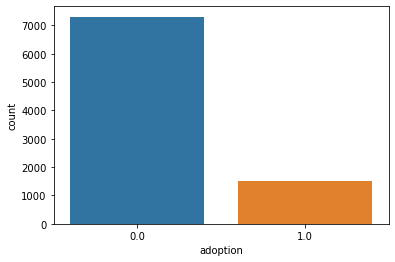

In [13]:
_ = sns.countplot(x='adoption',data=user_data)
plt.show()

Even without considering the users for whom the login data is missing, we have a very bad data distribution. It is completely imbalanced and we may need to balance it.

Let us check the other variables first

In [58]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adoption                    8823 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)


So the columns adoption, invited_by_user_id and last_session_creation_time have null values. Out of these, last_session_creation_time is for users who have logged in at least once and should have the same user_id's as adoption. Let's verify.

In [36]:
print(user_data[user_data.adoption.isnull()].last_session_creation_time.unique())
print(len(user_data[user_data.adoption.isnull()].last_session_creation_time))

[nan]
3177


This proves our assumption.

Now invited_by_user_id has id's of users that lead to user sign-up. So this column may or may not be relevelant on its own. We can define a categorical column by_invitation that is binary and marks whether the user joined by invitation or not. At the same time, we can check whether any particular user's invitation may have led to more people joining.

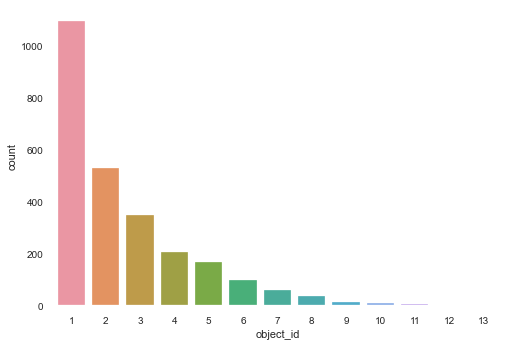

In [49]:
_=sns.countplot(x=user_data.groupby('invited_by_user_id').object_id.count())
plt.show()

So majority of people have referred <5 people which doesn't seem very helpful on its own. So lets drop this column

In [75]:
user_data['by_invitation']=[not i for i in user_data.invited_by_user_id.isnull()]

In [76]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoption,by_invitation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,True


In [77]:
user_data = user_data.drop('invited_by_user_id',axis=1)

In [78]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   adoption                    8823 non-null   float64       
 10  by_invitation               12000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), o

Now we can make the missing entries in adoption column to all zeros indicating that since these users have never logged in, they are not adopted users yet. We can set all these users to have a zero value in last_session_creation_time.

In [93]:
user_data['adoption']=np.nan_to_num(user_data.adoption)

In [94]:
user_data.adoption.unique()

array([0., 1.])

In [96]:
user_data['last_session_creation_time'] = np.nan_to_num(user_data.last_session_creation_time)

In [97]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   adoption                    12000 non-null  float64       
 10  by_invitation               12000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), o

All nan values are now taken care of. We may want to convert the categorical data to numeric.

In [101]:
user_data.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)


This column will have to be converted. 


In [179]:
transformed_data =pd.get_dummies(user_data, columns=["creation_source",'adoption'], prefix=["Creation_source",'adoption']) 

In [181]:
transformed_data=transformed_data.drop(['adoption_0.0'],axis=1)

In [182]:
transformed_data.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,by_invitation,Creation_source_0,Creation_source_1,Creation_source_2,Creation_source_3,Creation_source_4,adoption_1.0
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,True,1,0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,True,0,1,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,True,0,1,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,True,1,0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,True,1,0,0,0,0,0


dropping the identity values and keeping only required columns.

In [183]:
transformed_data = transformed_data.drop(['name','email'],axis=1)
transformed_data['creation_time_delta'] = (transformed_data.creation_time - transformed_data.creation_time.min())/ np.timedelta64(1,'D')
transformed_data = transformed_data.drop(['creation_time'],axis=1)


#### Now we split the dataset into train and test sets.


In [184]:
from sklearn.model_selection import train_test_split

In [194]:
X = transformed_data.drop(['adoption_1.0'],axis=1)
Y = transformed_data.loc[:,'adoption_1.0']

X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size = 0.8,stratify=Y)

C:\Users\roshn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Here we used stratify=Y because the data is not balanced. Most of the users are not adopted. 

We could have decided to balance the dataset using resmapling with replacement if we decided to use Logistic regression. But since Tree based classifiers work better with such unbalanced datasets, we dive into those first. 

In [157]:
from sklearn.ensemble import RandomForestClassifier

In [195]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

C:\Users\roshn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [196]:
y_pred = model.predict(X_test)

In [200]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9729166666666667
[[2088    9]
 [  56  247]]


ROC score - 0.966


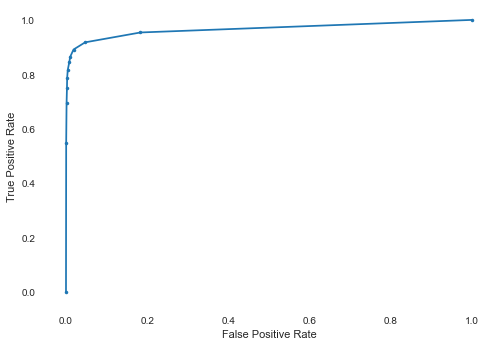

In [210]:
#AUC ROC curve, precision and recall
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print('ROC score - %.3f'%auc)

fpr, tpr, _ = roc_curve(y_test, y_prob)
_ = plt.plot(fpr, tpr, marker='.', label='Random Forest Classifier')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
plt.show()

This is the basic model. We could further finetune the hyperparameters for the model to improve accuracy.